## Exploratory Data Analysis / Feature Extraction

In [1]:
from os import walk
import numpy as np
import matplotlib.pyplot as plt

#imports for WAV2VEC2
import torch
import torchaudio
from transformers import Wav2Vec2Processor, Wav2Vec2Model

In [2]:
# parse the file names into a numpy matrix, each row represents one file.
RAW_DATA_PATH = '../data/raw'
dirs = []
for (dirpath, dirnames, _) in walk(RAW_DATA_PATH):
    for d in dirnames:
        if d.startswith("Actor"):
            dirs.append(dirpath+'/'+d)
    break
    
all_files = []
for actor in dirs:
    for(_,_,files) in walk(actor):
        all_files+=[i.split('.')[0].split('-') for i in files]
        break
all_files = [[int(i) - 1 for i in row] for row in all_files]

files = np.array(all_files)
print(files)

[[ 2  0  4 ...  1  0 15]
 [ 2  0  5 ...  1  1 15]
 [ 2  0  5 ...  0  1 15]
 ...
 [ 2  0  1 ...  0  0  7]
 [ 2  0  1 ...  1  0  7]
 [ 2  0  0 ...  1  1  7]]


In [3]:
def matrix_to_filename(matrix, RAW_DATA_PATH):
    filepaths = []
    for row in matrix:
        filename = ''
        for col in row:
            filename+=str(col+1).zfill(2)
            filename+='-'
        filename = filename[:-1]
        filename+='.wav'
        filepaths.append(RAW_DATA_PATH+'/Actor_'+str(row[6]+1).zfill(2)+'/'+filename)
        # print(filename)
    return filepaths
def plot_counts(files):
    print(f"Total number of files {files.shape[0]}")

    labels = [['full-AV', 'video-only', 'audio-only'],
             ['speech', 'song'],
             ['neutral' , 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust','surprised'],
             ['normal', 'strong'],
             ['Kids are talking by the door', 'Dogs are sitting by the door'],
             ['1st repetition', '2nd repetition'],
             ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']
             ]
    titles = ['Modality', 'Vocal channel', 'Emotion', 'Emotional intensity' ,'Statement','Repetition' ,'Actor']
    
    fig, ax = plt.subplots(2, 4, figsize=(20, 10)) 
    inds = [(0,0), (0,1), (0,2), (0,3), (1,0), (1,1), (1,2), (1,3)]
    for i in range(7):
        unique, counts = np.unique(files[:, i], return_counts = True)
        unique = np.array(labels[i])[unique]
        ax[inds[i]].bar(unique, counts)
        ax[inds[i]].set_title(titles[i])
    ax[inds[-1]].axis('off')
    plt.suptitle("Count Plots")
    plt.tight_layout()
    plt.show()

Total number of files 1440


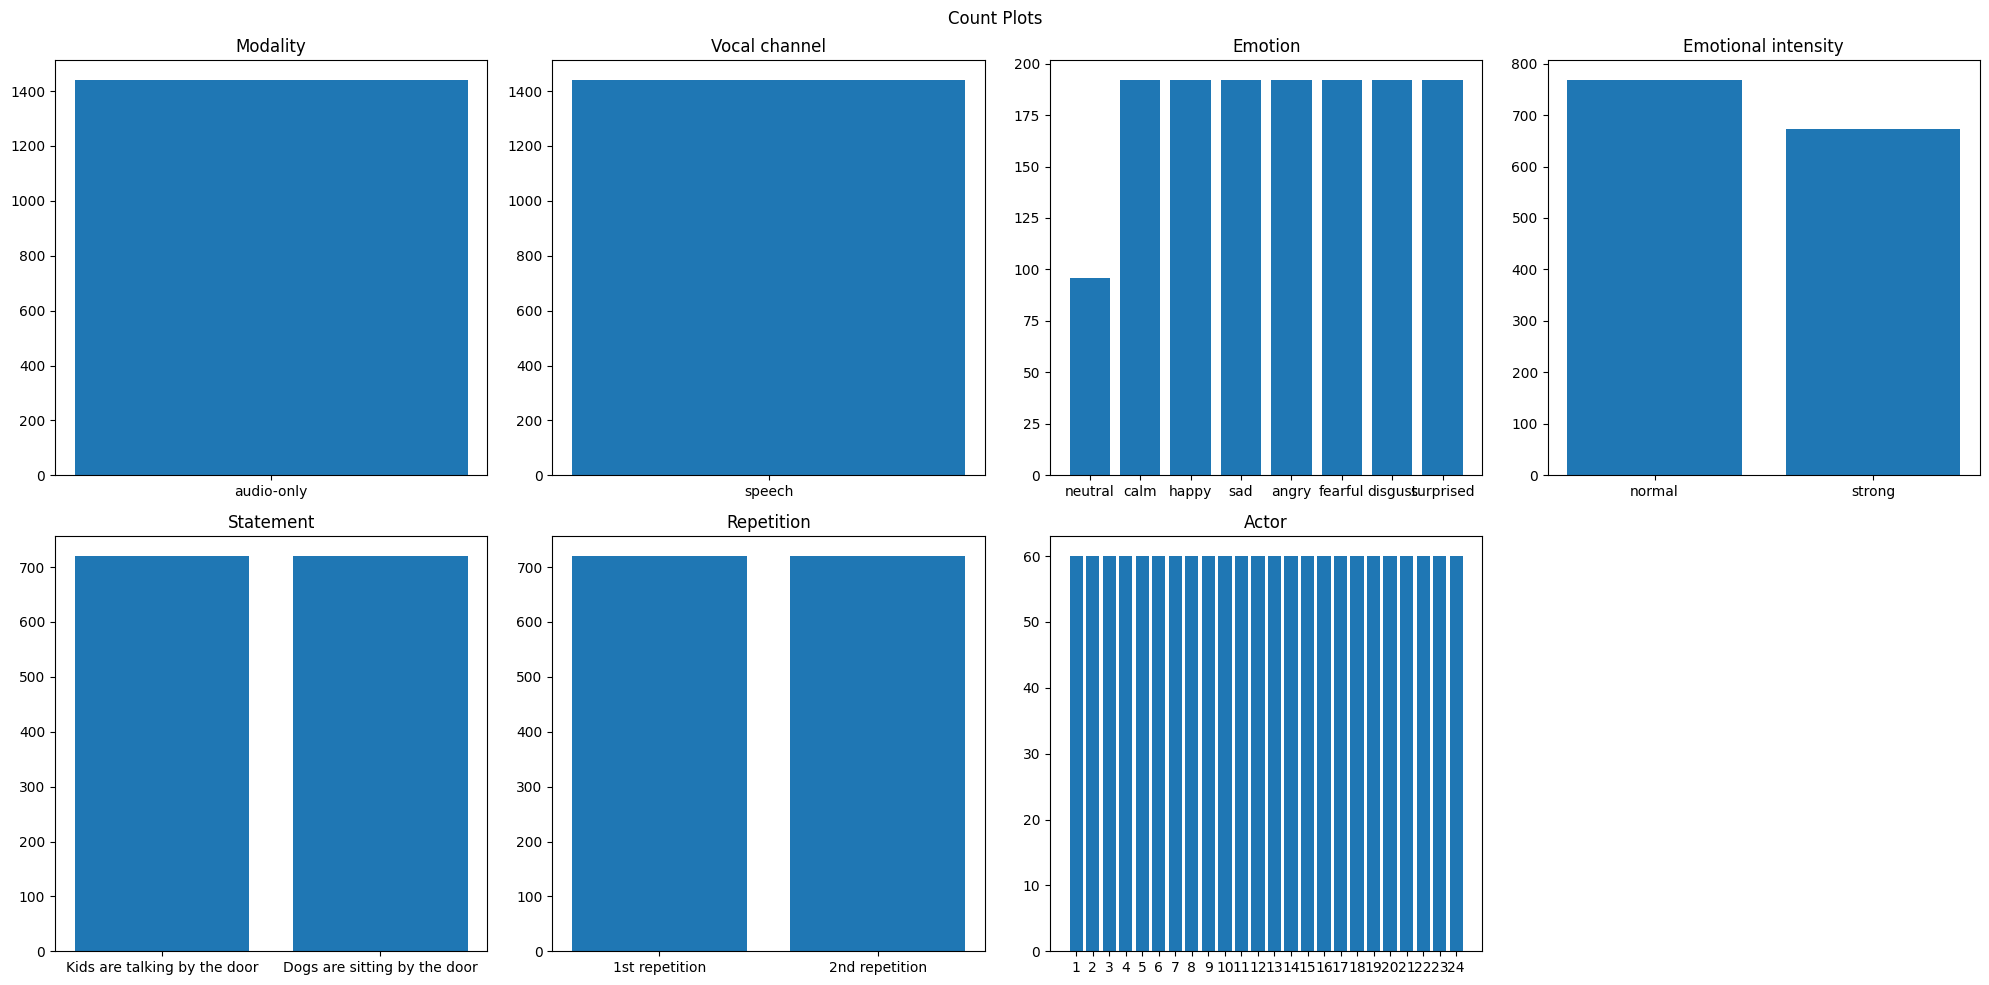

In [4]:
plot_counts(files)

Total number of files 96


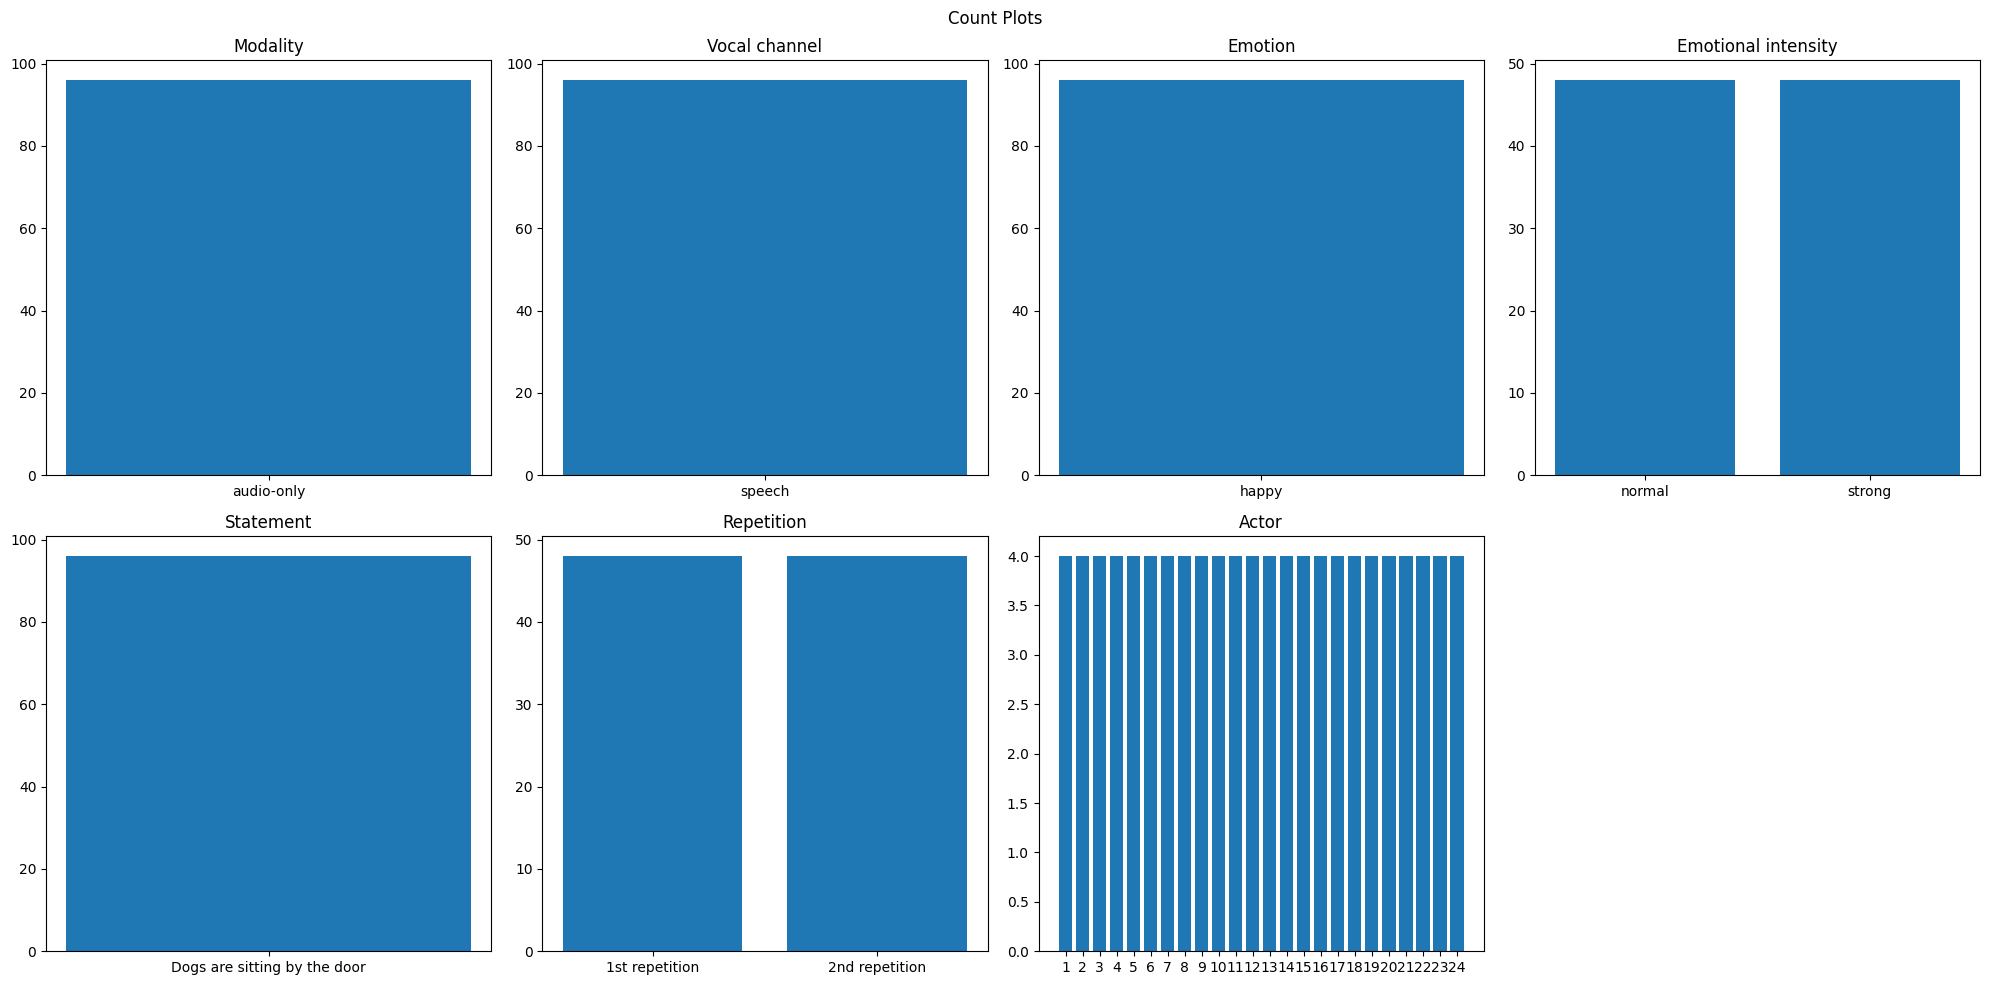

In [5]:
# plot only happy files with "dogs are sitting by the door"
mask = (files[:, 2] == 2 )
mask2 = (files[:, 4] == 1 )
extracted = files[mask&mask2]
plot_counts(extracted)

In [6]:
# average audio of all happy saying "dogs are sitting by the door"
import librosa 
import librosa.display
from IPython.display import Audio, Image, display

filepaths = matrix_to_filename(extracted, RAW_DATA_PATH)
all_samples = []
for file in filepaths:
    samples, sample_rate = librosa.load(file, sr=None)
    all_samples.append(samples)

mn = min(len(row) for row in all_samples)
print(mn)

truncated_data = [row[:mn] for row in all_samples]
average_audio = np.mean(np.array(truncated_data), axis = 0)
Audio(data=average_audio, rate=48000)



150551


### Todo
Mel-Frequency Cepstral Coefficients (MFCC) - Short term power spectrum of sound, divides frequencies based on mel scale over time.

Wav2Vec - Open source model by Meta AI,  self supervised learning of speech representations from audio data

Zero Crossing Rate - Number of times a sound wave crosses the x-axis

Root Mean Square  - Measuring average power of a sound signal over time

Spectral Centroid - Amplitude weighted mean of signal frequencies

Spectral Rolloff - Frequency below which 99% of the energy lies under


# Navneet's Wav2Vec2 EDA Section

### Load the pretrained model (base english speech version)

In [ ]:
#device
device = "cuda" if torch.cuda.is_available() else "cpu"

#Load the pretrained model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h", dtype=torch.float16, attn_implementation="flash_attention_2")

#model
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-large-960h").to(device)

#preprocess your audio
input_audio = average_audio

#Wav2Vec2 expects 16kHz sample rate so resample 
input_audio_resampled = librosa.resample(input_audio, orig_sr=48000, target_sr=16000)

#convert to model input format
inputs = processor(input_audio_resampled, sampling_rate=16000, return_tensors="pt").to(device)

#Extract the embeddings 
with torch.no_grad():
    outputs = model(**inputs)

#Take mean across time dimension to get single vector representation
embedding = outputs.last_hidden_state.mean(dim=1)
print(embedding.shape)
    

In [8]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")


False
CPU only
